<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/11_2_Attention_Pooling_by_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [2]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as FF
from d2l import torch as d2l
d2l.use_svg_display()

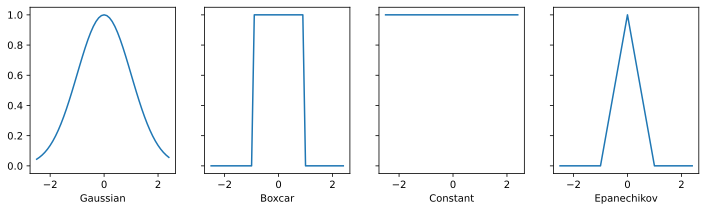

In [4]:
def gaussian(x):
  return torch.exp(-x**2/ 2)

def boxcar(x):
  return torch.abs(x) < 1.0

def constant(x):
  return 1.0 + 0 * x

def epanechikov(x):
  return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12,3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x= torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
  ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
  ax.set_xlabel(name)
d2l.plt.show()

In [5]:
def f(x):
  return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0,5,0.1)
y_val = f(x_val)

In [6]:
def nadarya_watson(x_train, y_train, x_val, kernel):
  dists = x_train.reshape((-1, 1)) - x_val.reshape((1,-1))
  k = kernel(dists).type(torch.float32)
  attention_w = k/ k.sum(0)
  y_hat  = y_train@attention_w
  return y_hat, attention_w

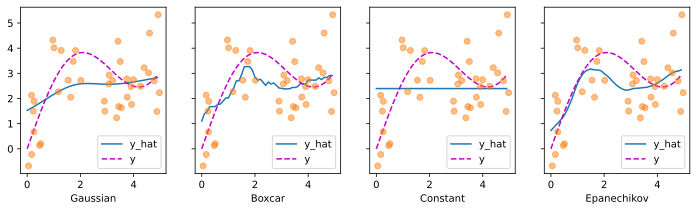

In [19]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
  fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12,3))
  for kernel, name, ax in zip(kernels, names, axes):
    y_hat, attention_w = nadarya_watson(x_train,y_train, x_val, kernel)
    if attention:
      pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
    else:
      ax.plot(x_val, y_hat)
      ax.plot(x_val, y_val, 'm--')
      ax.plot(x_train, y_train, 'o', alpha = 0.5)
    ax.set_xlabel(name)
    if not attention:
      ax.legend(['y_hat', 'y'])
  if attention:
    fig.colorbar(pcm,ax=axes, shrink=0.7)



plot(x_train, y_train, x_val, y_val, kernels,names)

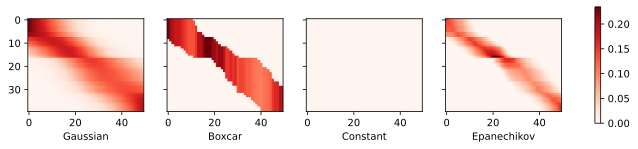

In [21]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

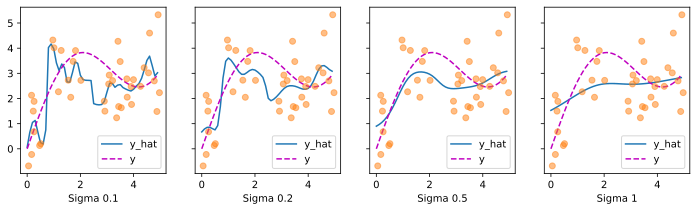

In [22]:
sigmas = (0.1, 0.2,0.5,1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
  return (lambda x: torch.exp(-x**2 / (2 * sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

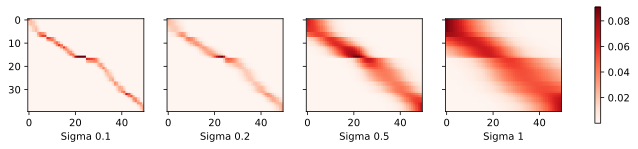

In [23]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)